# PMUs and Synchrophasors

---
## Non-Recursive Phasor estimation
This function implements the Non-Recursive method for phasor calculations.
![pic_non_recursive.png](pic_non_recursive.png)

In [1]:
import numpy as np
ctr = 0 # index for 3 point averaging
# non-recursive method
# Parameters
Nw = 6
f0 = 60
N = 20
amp = 30
phase = np.pi / 4
# X_nrec = np.zeros(Nw, dtype=complex)
# Xb = np.zeros((1, Nw), dtype=complex)

def non_recursive_est(Nw,N,f0,amp,phase):
    T0 = 1 / f0
    fs = f0 * N
    Nt = N * Nw
    dt = 1 / fs
    t = dt * np.arange(Nt)
    
    # Generate the signal x
    x = amp * np.cos(2 * np.pi * f0 * t + phase)
    
    # Initialize phasors
    X1 = np.zeros(Nw, dtype=complex)
    th = 2 * np.pi / N
    
    for k in range(Nw):
        phasor_sum = 0
        for n in range(N):
            phasor_sum += (np.sqrt(2) / N) * (x[k + n] * np.exp(-1j * n * th))  # Phasor calculation
    
        X1[k] = phasor_sum
    return X1

X_nrec = non_recursive_est(Nw,N,f0,amp,phase)

## Recursive Phasor estimation
This function implements the Recursive method for phasor calculations.
![pic_recursive.png](pic_recursive.png)
![pic_off_nominal_1.png](pic_off_nominal_1.png)
![pic_off_nominal_2.png](pic_off_nominal_2.png)

In [2]:
#recursive
fn = 50     # Nominal frequency
def recursive_est(Nw,N,f0,fn,amp,phase):
    Nt = N * Nw
    fs = fn * N   # Sampling freq
    dt = 1 / fs
    t = dt * np.arange(Nt)
    
    fs1 = N * f0
    dt1 = 1/fs1
    t1 = dt1 * np.arange(Nt)
    
    # Generate the signal x
    x = amp * np.cos(2 * np.pi * f0 * t + phase)
    x1 = amp * np.cos(2 * np.pi * f0 * t1 + phase)
    
    X = np.zeros(Nw, dtype=complex)
    Xa_1 = np.zeros(Nw, dtype=complex)
    Xa_2 = np.zeros(Nw, dtype=complex)
    Xb = np.zeros((1, Nw), dtype=complex)
    
    th = 2 * np.pi / N
    
    df = f0 - fn
    w0 = 2 * np.pi * fn
    dw = 2 * np.pi * df
    w = w0 + dw
    
    # Calculate P and Q
    if dw == 0:
        P = 1
        Q = 0
    else:
        P = (np.sin(N * (w - w0) * dt / 2)) / (N * np.sin((w - w0) * dt / 2)) * np.exp(1j * (N - 1) * (w - w0) * dt / 2)
        Q = (np.sin(N * (w + w0) * dt / 2)) / (N * np.sin((w + w0) * dt / 2)) * np.exp(-1j * (N - 1) * (w + w0) * dt / 2)
    
    for n in range(N):
        X[0] = X[0] + (np.sqrt(2) / N) * x1[n] * np.exp(-1j * n * th)
        
    for k in range(1, Nw):
        X[k] = X[k - 1] + (np.sqrt(2) / N) * (x1[N + k - 1] - x1[k - 1]) * np.exp(-1j * k * th)
    
    for k in range(Nw):
        Xb[0, k] = P * X[k] * np.exp(1j * k * (w - w0) * dt) + Q * X[k].conjugate() \
        * np.exp(-1j * k * (w + w0) * dt)
    
    Xa_1[0] = 0
    Xa_2[0] = 0
    
    for n in range(N):
        Xa_1[0] = Xa_1[0] + (np.sqrt(2) / N) * x[n] * np.exp(-1j * n * th)
    
    for k in range(1, Nw):
        Xa_1[k] = Xa_1[k - 1] + (np.sqrt(2) / N) * (x[N + k - 1] - x[k - 1]) * np.exp(-1j * k * th)
    
    for n in range(N):
        Xa_2[0] = Xa_2[0] + (np.sqrt(2) / N) * x1[n] * np.exp(-1j * n * th)
    
    for k in range(1, Nw):
        Xa_2[k] = Xa_2[k - 1] + (np.sqrt(2) / N) * (x1[N + k - 1] - x1[k - 1]) * np.exp(-1j * k * th)
    
    # Calculate magnitudes and phases
    maga_1 = np.abs(Xa_1[-1])
    maga_2 = np.abs(Xa_2[-1])
    phasea_1 = np.rad2deg(np.angle(Xa_1[-1]))
    phasea_2 = np.rad2deg(np.angle(Xa_2[-1]))
    magb = np.abs(Xb[0, -1])
    phaseb = np.rad2deg(np.angle(Xb[0, -1]))

    return Xb
    
X_rec = recursive_est(Nw,N,f0,fn,amp,phase)

This function generates the Phase, Magnitude plots for the phasors calculated with Recursive method

In [3]:
def plot_mag_phase(mag_rec, phase_rec, Nw):
    x = np.arange(0, Nw)
    fig, (ax1,ax2) = plt.subplots(2,1,layout='constrained', sharex=True)
    ax1.plot(x, mag_rec,'or')
    ax1.set_ylabel('Magnitude')
    ax2.plot(x,phase_rec/np.pi*180,'+b')
    ax2.set_ylabel('Phase')
    ax2.set_xlabel('Samples')
    ax2.set_yticks([-180, -90, 0, 90, 180])
    fig.suptitle('Magnitude, Phase of Phasor with Recursive method')
    plt.show()

This function generates the phasor polar plots
![pic_three_point_avg.png](pic_three_point_avg.png)

Non-Recursive  -15.0000+15.0000j  Magnitude: 21.2132 , Phase: 2.3562
Recursive  -2.8325+21.4994j  Magnitude: 21.6851 , Phase: 1.7018


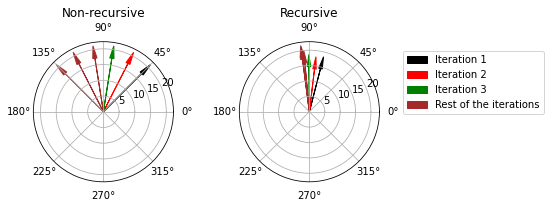

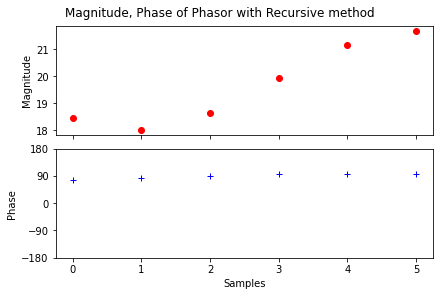

In [4]:
import matplotlib.pyplot as plt

def plot_phasors(Nw,N,X_nrec,X_rec,three_pavg = 0):
    global ctr
    fig, (ax1, ax2) = plt.subplots(1, 2,subplot_kw=dict(projection="polar"))
    ax1.set_title("Non-recursive")
    ax2.set_title("Recursive")
    fig.tight_layout(pad=2)
    colors = ["black", "red", "green", "brown"]
    phase_rec = np.zeros(Nw)
    mag_rec = np.zeros(Nw)
    # for 3-point averaging in recursive method
    flag = 0
    if Nw > N:
        ctr = ctr + 1
    if three_pavg == 1 and Nw > N:
        flag = 1
        k60=round(N/6)
        k120=round(N/3)
        Xs=np.zeros(3,dtype=complex)
        Xs[0] = X_rec[0,ctr]
        Xs[1] = X_rec[0,ctr+k60]
        Xs[2] = X_rec[0,ctr+k120]
        X_filtered = sum(Xs)/3
        X_rec[0,-1] = sum(Xs)/3

    for i in range(Nw):    #iterating over Nw elements
        #non-recursive
        mag_nrec = np.abs(X_nrec[i])
        phase_nrec = np.angle(X_nrec[i])
        #reursive
        mag_rec[i] = np.abs(X_rec[0,i])
        phase_rec[i] = np.angle(X_rec[0,i])
        if i == Nw-1:     # print the last calculated phasor information
            print("Non-Recursive ", "{:.4f}".format(X_nrec[i]), " Magnitude:", "{:.4f}".format(mag_nrec), ", Phase:","{:.4f}".format(phase_nrec))
            print("Recursive ", "{:.4f}".format(X_rec[0,i]), " Magnitude:", "{:.4f}".format(mag_rec[i]), ", Phase:", "{:.4f}".format(phase_rec[i]))
        # legend and colour generation. After first 4 iterations the colour of phasor defaults to brown
        # this is done so that the sequence of phasor generation can be distinguished    
        arr_label =None
        if i <= 3:
            arr_color = colors[i]
            if i <3:
                arr_label = "Iteration "+str(i+1)
            else:
                 arr_label = "Rest of the iterations"
        #polar plots
        ax1.arrow(phase_nrec, 0, 0, mag_nrec, length_includes_head=True,
              head_width=0.08, head_length=4, color=arr_color)
        ax2.arrow(phase_rec[i], 0, 0, mag_rec[i], length_includes_head=True,
              head_width=0.08, head_length=4, color=arr_color, label=arr_label)
    
    # snippet places the legend's lower left corner just outside the polar axes
    # at an angle of 67.5 degrees in polar coordinates.
    angle = np.deg2rad(-30)
    ax2.legend(loc="lower left",bbox_to_anchor=(.7 + np.cos(angle)/2, .7 + np.sin(angle)/2))
    
    plt.show()
    # phase, mag plot fn
    plot_mag_phase(mag_rec, phase_rec, Nw)

plot_phasors(Nw,N,X_nrec,X_rec)

## Generate your plots
Now let's generate more data points.
If you want to change the signal parameters, go ahead! Click on the reset button and tweak the the parameters in the input box.
See how the phasors are calculated and compare the the 2 methods.

In [5]:
from ipywidgets import *

out = widgets.Output()
#function to run the phasor calculation and plot, invoked from the button press action
def gen_plot():
    out.clear_output() # clears the output field for the new plot
    global Nw
    Nw = Nw +1 # picking new window, to calculate the next datapoint
    f0 = in_f0.value
    N = in_N.value 
    fn = in_fn.value 
    amp = in_amp.value
    three_pavg = in_3p.value
    phase = np.deg2rad(in_pahse.value)
    X_nrec = non_recursive_est(Nw,N,f0,amp,phase)
    X_rec = recursive_est(Nw,N,f0,fn,amp,phase)
    plot_phasors(Nw,N,X_nrec,X_rec, three_pavg) 
    
items_layout = Layout( width='auto') # override the default width of the button to 'auto' to let the button grow
form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-around')
#elements in the form
in_f0 = BoundedIntText(value=60, min=0, step=1, description='Frequency(f0):', disabled=False)
in_3p = widgets.Dropdown(options=[('Yes', 1), ('No', 0)], value=0, description='3-point Avg.:')
in_N = BoundedIntText(value=20, min=0, step=1, description='Samples(N):', disabled=False)
in_fn = BoundedIntText(value=50, min=0, step=1, description='Nominal Frequency(fn):', disabled=False)
in_amp = BoundedIntText(value=30, min=0, step=1, description='Amplitude:', disabled=False)
in_pahse = BoundedIntText(value=45, min=0, step=1, description='Phase:', disabled=False)
in_btn_gen = Button(description="Generate Plot",style=ButtonStyle(button_color='moccasin'))
in_btn_reset = Button(description="Reset",style=ButtonStyle(button_color='lightgrey'))

#columns in the form with Box element
form_items = [Box([in_f0, in_fn], layout=form_item_layout),
    Box([in_amp, in_pahse], layout=form_item_layout),
    Box([in_N, in_3p ], layout=form_item_layout),
    Box([in_btn_reset, in_btn_gen], layout=form_item_layout),
    Box([out], layout=form_item_layout)]
#formatting the form as Box
form = Box(form_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_content='stretch',
    width='70%'))

# generate button
def on_button_clicked(p):
    with out:
        gen_plot()
#reset button
def on_reset_clicked(p):
    global Nw, ctr
    Nw=0
    ctr=0

in_btn_gen.on_click(on_button_clicked)
in_btn_reset.on_click(on_reset_clicked)

form #display the parameter selection & plots


Box(children=(Box(children=(BoundedIntText(value=60, description='Frequency(f0):'), BoundedIntText(value=50, d…